## 2. Preprocessing

All data is preprocessed according to the following steps.
1. Data is split in a training set of 80% of the data and a test set of 20% of the data.
2. Missing feature data is imputed using the mean. Missing target data is inferred from other available metadata.
3. Outliers are removed, data is normalized and centered. Target Y1 is binned per 10 listenings and target Y2 is binned per year.

Next to feature set f1, which contains all features, two more feature sets are created with PCA dimensionality reduction. For feature set f2 PCA is applied per column name group, and for feature set f3 PCA is applied on the total of features.

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme()

In [2]:
class Feature_reader():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def min(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='min']
        return self.format(select)
    
    def max(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='max']
        return self.format(select)

    def median(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='median']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def skew(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='skew']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)

    def per_nns(self):
        """
        List of lists per name1, name2, stat, per name1, name2.
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['stat'], sort=False)] for idx, grp in select.groupby(by=['name1', 'name2'])]
        return select
    
    def per_sn(self):
        """
        List of lists per stat, n. 
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['n'], sort=False)] for idx, grp in select.groupby(by=['stat'], sort=False)]
        return select

fts = Feature_reader('features.csv')

### 2.1 Train-test split

In [ ]:
# Create train and test set and save csv's.
# Takes 1,5 min

# import pandas as pd
# from sklearn.model_selection import train_test_split

# df_music = pd.read_csv('data/music_data.csv')
# df_meta = pd.read_csv('data/metadata.csv')

# train, test = train_test_split(df_music, test_size=0.2, random_state=1)

# train.to_csv('data/data_train.csv')
# test.to_csv('data/data_test.csv')
# df_meta.iloc[train.index].to_csv('data/metadata_train.csv', index=False)
# df_meta.iloc[test.index].to_csv('data/metadata_test.csv', index=False)

# train test sampling with respect to balancing cats??


In [52]:
# Read data
df = pd.read_csv('data/data_train.csv')
df_meta = pd.read_csv('data/metadata_train.csv', parse_dates=['album_date_created', 'album_date_released', 'track_date_created']) #There are more datetimes

df.drop(df.columns[[0,1]],axis=1,inplace=True)
df['popularity'] = df_meta['track_listens']
df['release'] = df_meta['album_date_released']

### 2.2 Missing data

In [5]:
df_meta[['album_date_created', 'album_date_released']]

,album_date_created,album_date_released
0,2010-09-04 15:47:48,2010-09-04
1,2014-11-13 18:40:58,2014-11-13
2,2013-11-19 12:14:39,2008-03-29
3,2011-01-03 16:16:30,2011-01-01
4,NaT,NaT
...,...,...
85254,2012-11-30 14:26:41,2012-12-01
85255,2016-09-18 11:23:03,NaT
85256,2009-03-12 08:13:10,NaT
85257,2015-03-18 04:51:41,2015-03-18


In [26]:
na = df_meta[['album_date_created', 'album_date_released']].isna()

ff = na.loc[(na['album_date_released']==False) & (na['album_date_created']==False)].shape[0]
ft = na.loc[(na['album_date_released']==False) & (na['album_date_created']==True)].shape[0]
tf = na.loc[(na['album_date_released']==True) & (na['album_date_created']==False)].shape[0]
tt = na.loc[(na['album_date_released']==True) & (na['album_date_created']==True)].shape[0]

print(f'\
               | created != na | created = na \n\
released != na |     {ff}     |      {ft}    \n\
released = na  |     {tf}     |      {tt}    \n\
')

               | created != na | created = na 
released != na |     56344     |      0    
released = na  |     26075     |      2840    



112.0


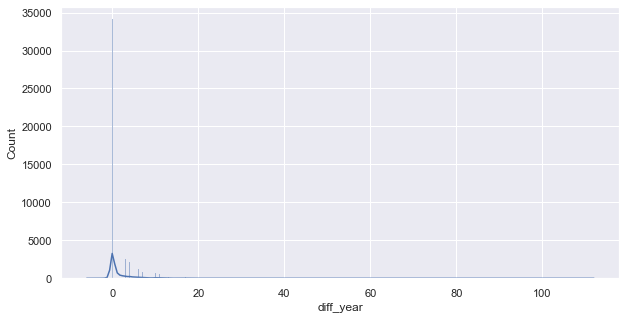

In [64]:
df_year = df_meta[['album_date_created', 'album_date_released', 'track_date_created']].copy()
df_year['created'] = df_year['album_date_created'].dt.year
df_year['released'] = df_year['album_date_released'].dt.year
df_year['track'] = df_year['track_date_created'].dt.year
df_year['diff_days'] = df_year['album_date_created'] - df_year['album_date_released']
df_year['diff_year'] = df_year['created'] - df_year['released']

# print(df_year.loc[df_year['diff_year']==0].shape[0])
# print(df_year.loc[df_year['diff_year']==1].shape[0])
# print(df_year.loc[df_year['diff_year']>1].shape[0])

# print(df_year.loc[df_year['diff_year']>1].sum())

fig, axs = plt.subplots(ncols=1, figsize=(10,5))

sns.histplot(data=df_year, x="diff_year", kde=True);

# ax1.set(title="Distribution release with density estimate")

fig;

In [42]:
print(df_meta.columns)

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

In [50]:
print(df_meta.isna().sum())

track_id                        0
album_comments                  0
album_date_created           2840
album_date_released         28915
album_engineer              73028
album_favorites                 0
album_id                        0
album_information           18719
album_listens                   0
album_producer              70823
album_tags                      0
album_title                   818
album_tracks                    0
album_type                   5227
artist_active_year_begin    67141
artist_active_year_end      81017
artist_associated_labels    73897
artist_bio                  28407
artist_comments                 0
artist_date_created           694
artist_favorites                0
artist_id                       0
artist_latitude             49667
artist_location             29159
artist_longitude            49667
artist_members              47870
artist_name                     0
artist_related_projects     74806
artist_tags                     0
artist_website

### 2.3 Outliers

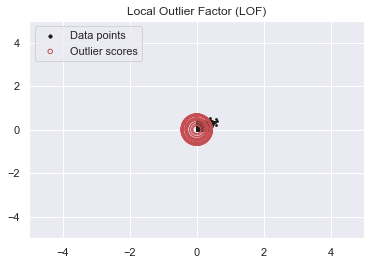

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# # Generate train data
# X_inliers = 0.3 * np.random.randn(100, 2)
# X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# # Generate some outliers
# X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
# X = np.r_[X_inliers, X_outliers]

X = df[fts.all()].to_numpy()

# n_outliers = len(X_outliers)
# ground_truth = np.ones(len(X), dtype=int)
# ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
# clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
# y_pred = clf.fit_predict(X)
# n_errors = (y_pred != ground_truth).sum()

# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train)

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

                lof
count  8.525900e+04
mean  -1.055496e+09
std    5.792742e+10
min   -4.177909e+12
25%   -1.121533e+00
50%   -1.052359e+00
75%   -1.013872e+00
max   -9.421950e-01


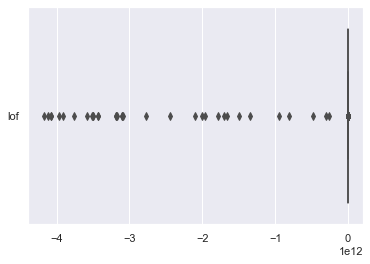

In [79]:
lofs = pd.DataFrame({'lof': clf.negative_outlier_factor_})

print(lofs.describe())

sns.boxplot(data=lofs, orient='h');


### 2.4 Feature sets